<a href="https://colab.research.google.com/github/Vanchnav/Credit_Card_Fraud_Detection-LogReg_DT_RF_Balanced/blob/main/Credit_card_fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#importing required packages

#modelues for EDA steps
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#modules for data cleaning and data analysis
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats

#modules for model building
#algorithms for sampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

#baseline linear model
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#modules for hyper parameter tuning
from sklearn.model_selection import GridSearchCV

#modules for model evaluation
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, accuracy_score, f1_score, r2_score
from sklearn.metrics import precision_recall_curve, roc_curve

#modules for avoiding warnings
import warnings
warnings.filterwarnings('ignore')

#setting backend for matplotlib
%matplotlib inline

#setting formatting options
pd.options.display.max_columns = 100
pd.options.display.max_rows = 900
pd.set_option('float_format' , '{:f}'.format)

#setting plot style
plt.style.use('seaborn-darkgrid')

In [4]:
#loading the dataset
from google.colab import files
import io
uploaded = files.upload()

Saving fraudTest.csv to fraudTest.csv
Saving fraudTrain.csv to fraudTrain.csv


In [5]:
#Загружаем датасеты
fraud_train = pd.read_csv(io.BytesIO(uploaded['fraudTrain.csv']))
fraud_test = pd.read_csv(io.BytesIO(uploaded['fraudTest.csv']))

#Соединяем
df = pd.concat([fraud_train, fraud_test]).reset_index()

df.drop(df.columns[:2], axis=1, inplace=True)
df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.970000,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.078800,-81.178100,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.230000,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.887800,-118.210500,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.110000,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.180800,-112.262000,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.000000,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.230600,-112.113800,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.960000,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.420700,-79.462900,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [6]:
#Переводим дату в формает to_datetime
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
print(df.dtypes['trans_date_trans_time'])
df.head()

datetime64[ns]


,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.970000,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.078800,-81.178100,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.230000,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.887800,-118.210500,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.110000,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.180800,-112.262000,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.000000,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.230600,-112.113800,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.960000,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.420700,-79.462900,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [7]:
#Смотрим на количество уникальных
df.nunique()

trans_date_trans_time    1819551
cc_num                       999
merchant                     693
category                      14
amt                        60616
first                        355
last                         486
gender                         2
street                       999
city                         906
state                         51
zip                          985
lat                          983
long                         983
city_pop                     891
job                          497
dob                          984
trans_num                1852394
unix_time                1819583
merch_lat                1754157
merch_long               1809753
is_fraud                       2
dtype: int64

Теперь, поскольку в столбце 'trans_date_trans_time' много уникальных значений, мы разделим столбец на час, день и месяц-год, чтобы получить больше информации из столбца и присоединить эти дополнительные столбцы к нашему исходному фрейму данных

In [8]:
#Час
df['trans_hour'] = df['trans_date_trans_time'].dt.hour
#День недели
df['trans_day_of_week'] = df['trans_date_trans_time'].dt.day_name()
#Месяц-год
df['trans_year_month'] = df['trans_date_trans_time'].dt.to_period('M')

df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,trans_hour,trans_day_of_week,trans_year_month
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.970000,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.078800,-81.178100,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,0,Tuesday,2019-01
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.230000,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.887800,-118.210500,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,0,Tuesday,2019-01
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.110000,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.180800,-112.262000,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,0,Tuesday,2019-01
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.000000,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.230600,-112.113800,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,0,Tuesday,2019-01
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.960000,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.420700,-79.462900,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,0,Tuesday,2019-01


Давайте теперь также узнаем возраст клиента на момент совершения сделки.
Эта переменная может помочь нам определить, какая возрастная группа людей подвергается мошенничеству.

In [9]:
#Ищем возраст
#Переводим 'dob' в datetime
df['dob'] = pd.to_datetime(df['dob'])
df['age'] = np.round((df['trans_date_trans_time'] - 
                      df['dob'])/np.timedelta64(1, 'Y'))
df.age.head()

0   31.000000
1   41.000000
2   57.000000
3   52.000000
4   33.000000
Name: age, dtype: float64

Теперь, поскольку мы извлекли отдельные переменные из столбца 'trans_date_trans_time', можно безопасно удалить столбец, поскольку он не предоставляет нам никакой дополнительной информации.

И, поскольку мы также извлекли возраст клиентов, мы можем безопасно удалить переменную 'dob', поскольку она не предоставляет нам никакой дополнительной информации в этом контексте.

Кроме того, переменные "first", "last" содержат личную информацию, позволяющую установить личность. Эти функции вызывают опасения по поводу конфиденциальности и, более того, не являются необходимыми в контексте нашего анализа. Поэтому мы также отбросим эти переменные.

In [10]:
df.drop(['trans_date_trans_time','first', 'last', 'dob'] , axis=1, inplace=True)
df.head()

,cc_num,merchant,category,amt,gender,street,city,state,zip,lat,long,city_pop,job,trans_num,unix_time,merch_lat,merch_long,is_fraud,trans_hour,trans_day_of_week,trans_year_month,age
0,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.970000,F,561 Perry Cove,Moravian Falls,NC,28654,36.078800,-81.178100,3495,"Psychologist, counselling",0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,0,Tuesday,2019-01,31.000000
1,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.230000,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.887800,-118.210500,149,Special educational needs teacher,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,0,Tuesday,2019-01,41.000000
2,38859492057661,fraud_Lind-Buckridge,entertainment,220.110000,M,594 White Dale Suite 530,Malad City,ID,83252,42.180800,-112.262000,4154,Nature conservation officer,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,0,Tuesday,2019-01,57.000000
3,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.000000,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.230600,-112.113800,1939,Patent attorney,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,0,Tuesday,2019-01,52.000000
4,375534208663984,fraud_Keeling-Crist,misc_pos,41.960000,M,408 Bradley Rest,Doe Hill,VA,24433,38.420700,-79.462900,99,Dance movement psychotherapist,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,0,Tuesday,2019-01,33.000000


Теперь, когда в нашем фрейме данных есть только необходимые данные, мы перейдем к этапу обработки данных, то есть к обработке пропущенных значений, кодированию переменных и масштабированию переменных везде, где это требуется.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 22 columns):
 #   Column             Dtype    
---  ------             -----    
 0   cc_num             int64    
 1   merchant           object   
 2   category           object   
 3   amt                float64  
 4   gender             object   
 5   street             object   
 6   city               object   
 7   state              object   
 8   zip                int64    
 9   lat                float64  
 10  long               float64  
 11  city_pop           int64    
 12  job                object   
 13  trans_num          object   
 14  unix_time          int64    
 15  merch_lat          float64  
 16  merch_long         float64  
 17  is_fraud           int64    
 18  trans_hour         int64    
 19  trans_day_of_week  object   
 20  trans_year_month   period[M]
 21  age                float64  
dtypes: float64(6), int64(6), object(9), period[M](1)
memory usage: 310

Объекты с типом данных object должны быть преобразованы в формат, который можно смоделировать, для этого мы закодируем эти категориальные значения в более поздней части нашего анализа.

В наборе данных нет пропущенных значений.

In [12]:
#Делаем копию
df_org = df.copy()

**EDA**

In [13]:
df.shape

(1852394, 22)

In [14]:
df.head()

,cc_num,merchant,category,amt,gender,street,city,state,zip,lat,long,city_pop,job,trans_num,unix_time,merch_lat,merch_long,is_fraud,trans_hour,trans_day_of_week,trans_year_month,age
0,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.970000,F,561 Perry Cove,Moravian Falls,NC,28654,36.078800,-81.178100,3495,"Psychologist, counselling",0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,0,Tuesday,2019-01,31.000000
1,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.230000,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.887800,-118.210500,149,Special educational needs teacher,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,0,Tuesday,2019-01,41.000000
2,38859492057661,fraud_Lind-Buckridge,entertainment,220.110000,M,594 White Dale Suite 530,Malad City,ID,83252,42.180800,-112.262000,4154,Nature conservation officer,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,0,Tuesday,2019-01,57.000000
3,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.000000,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.230600,-112.113800,1939,Patent attorney,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,0,Tuesday,2019-01,52.000000
4,375534208663984,fraud_Keeling-Crist,misc_pos,41.960000,M,408 Bradley Rest,Doe Hill,VA,24433,38.420700,-79.462900,99,Dance movement psychotherapist,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,0,Tuesday,2019-01,33.000000


In [15]:
df.describe()

,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud,trans_hour,age
count,1852394.000000,1852394.000000,1852394.000000,1852394.000000,1852394.000000,1852394.000000,1852394.000000,1852394.000000,1852394.000000,1852394.000000,1852394.000000,1852394.000000
mean,417386038393710400.000000,70.063567,48813.258191,38.539311,-90.227832,88643.674509,1358674218.834364,38.538976,-90.227940,0.005210,12.806119,46.266173
std,1309115265318734848.000000,159.253975,26881.845966,5.071470,13.747895,301487.618344,18195081.387560,5.105604,13.759692,0.071992,6.815753,17.412388
min,60416207185.000000,1.000000,1257.000000,20.027100,-165.672300,23.000000,1325376018.000000,19.027422,-166.671575,0.000000,0.000000,14.000000
25%,180042946491150.000000,9.640000,26237.000000,34.668900,-96.798000,741.000000,1343016823.750000,34.740122,-96.899440,0.000000,7.000000,33.000000
50%,3521417320836166.000000,47.450000,48174.000000,39.354300,-87.476900,2443.000000,1357089331.000000,39.368900,-87.440694,0.000000,14.000000,44.000000
75%,4642255475285942.000000,83.100000,72042.000000,41.940400,-80.158000,20328.000000,1374581485.250000,41.956263,-80.245108,0.000000,19.000000,57.000000
max,4992346398065154048.000000,28948.900000,99921.000000,66.693300,-67.950300,2906700.000000,1388534374.000000,67.510267,-66.950902,1.000000,23.000000,96.000000


In [16]:
#Смотрим на процентное содержание мошеннических данных в датасете
100*df.is_fraud.value_counts(normalize=True)

0   99.478999
1    0.521001
Name: is_fraud, dtype: float64

Приведенные выше выходные данные указывают на то, что процент мошеннических транзакций в наборе данных составляет всего около 0,57%, а процент не мошеннических транзакций - 99,42%.

Таким образом, это несбалансированный набор данных, и необходимо сбалансировать данные, чтобы не допустить каких-либо искажений в нашем анализе.

**Amount**

Сумма является важной переменной при анализе мошенничества с кредитными картами.
Рассмотрим распределение сумм и попытаемся извлечь из этого некоторые выводы.

Давайте теперь посмотрим на распределение общей суммы, суммы мошенничества и суммы, не связанной с мошенничеством.

In [17]:
pd.concat(
    [df['amt'].describe(percentiles = [0.5,0.95,0.999]).reset_index().rename(columns={'index': 'Row Type', 'amt':'Overall Amt Distribution'}),
     df.loc[df['is_fraud']==0,['amt']].describe(percentiles = [0.5,0.95,0.999]).reset_index(drop = 1).rename(columns={'amt':'Non-Fraud Amt Distribution'}),
     df.loc[df['is_fraud']==1,['amt']].describe(percentiles = [0.5,0.95,0.999]).reset_index(drop = 1).rename(columns={'amt':'Fraud Amt Distribution'})], axis=1)

,Row Type,Overall Amt Distribution,Non-Fraud Amt Distribution,Fraud Amt Distribution
0,count,1852394.000000,1842743.000000,9651.000000
1,mean,70.063567,67.651278,530.661412
2,std,159.253975,153.548108,391.028873
3,min,1.000000,1.000000,1.060000
4,50%,47.450000,47.240000,390.000000
5,95%,195.340000,189.590000,1084.090000
6,99.9%,1517.241050,1519.622580,1293.127000
7,max,28948.900000,28948.900000,1376.040000


Среднее значение "Non-Fraud Amt Distribution" намного меньше, чем "Fraud Amt Distribution".
Это означает, что в заданном наборе транзакций со сбалансированным количеством точек данных о мошенничестве и не связанных с ним, средняя сумма транзакции amt мошенничества очень высока. Это означает, что сумма, потерянная в результате мошеннической операции, очень высока.

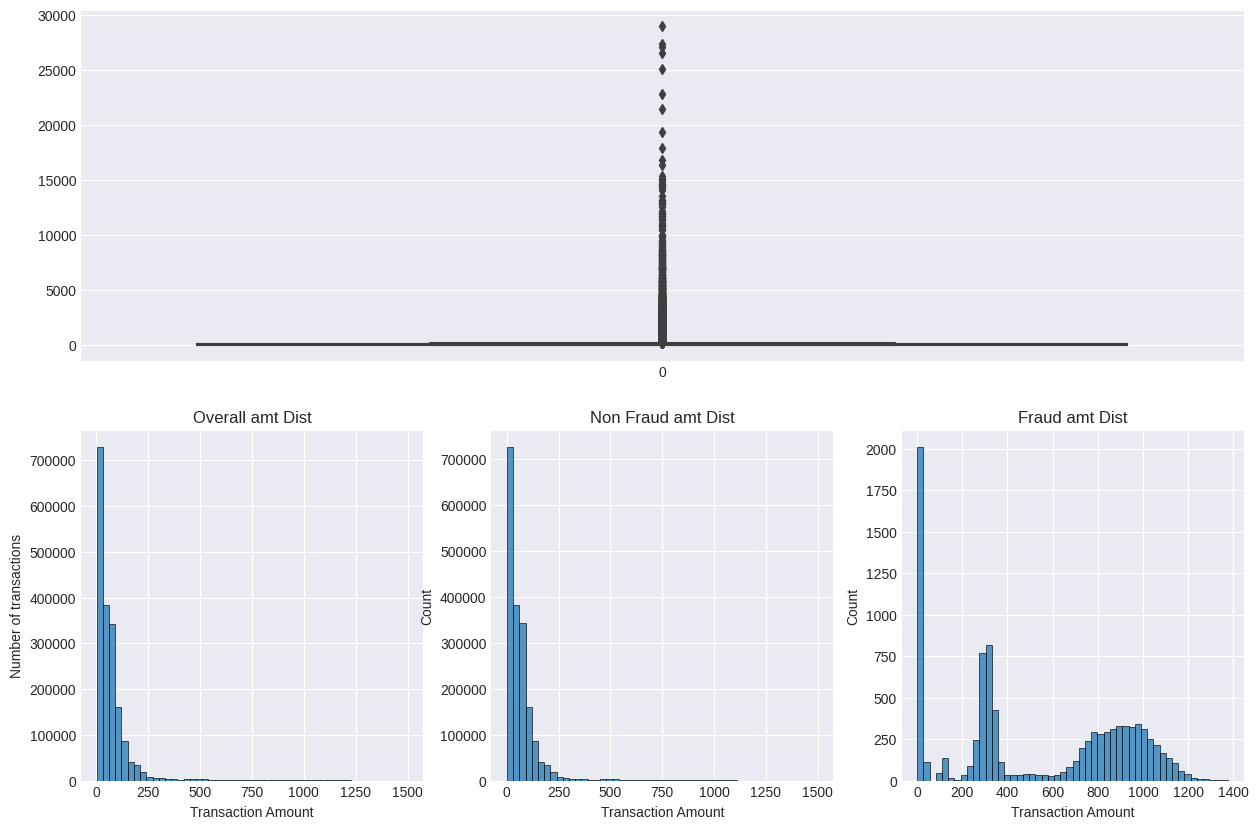

In [18]:
fig = plt.subplots(figsize=(15,10))

plots = []

plots.append(sns.boxplot(df.amt, ax=plt.subplot(211)))

plots.append(sns.histplot(df[df.amt <= 1500].amt, bins=50, ax=plt.subplot(234)))
plots.append(sns.histplot(df[(df.is_fraud==0) & (df.amt<=1500)].amt, bins=50, ax=plt.subplot(235)))
plots.append(sns.histplot(df[(df.is_fraud==1) & (df.amt<=1500)].amt, bins=50, ax=plt.subplot(236)))

#Тайтлы
plots[1].set_title('Overall amt Dist')
plots[2].set_title('Non Fraud amt Dist')
plots[3].set_title('Fraud amt Dist')

#Х лейблы
plots[1].set_xlabel('Transaction Amount')
plots[2].set_xlabel('Transaction Amount')
plots[3].set_xlabel('Transaction Amount')

#У лейблы
plots[1].set_ylabel('Number of transactions')

plt.show()

Из приведенных выше графиков можно отметить, что функция "amt" имеет много выбросов. Это означает, что разница в характеристике огромна.
Распределение общей суммы и суммы, не связанной с мошенничеством, аналогично при использовании аналогичных средств. Однако среднее значение графика суммы мошенничества кажется большим, чем у других распределений.
Кроме того, отчетливо видна асимметрия в данных.

Из приведенного выше графика, хотя среднее значение суммы мошенничества, по-видимому, больше, чем среднее значение суммы без мошенничества или общей суммы, можно заметить, что сумма мошенничества распределена равномерно и часто фиксирует низкое значение суммы по сравнению с другими распределениями.
Исходя из этого, можно заметить, что транзакция на сумму мошенничества часто происходит на небольшую сумму, часто около 200, а иногда и в диапазоне от 200 до 400.
Таким образом, транзакции, в которых задействована небольшая сумма, можно более тщательно отслеживать, чтобы выявить и предотвратить мошенничество с кредитными картами.

**Time data**

In [20]:
df_timeline01 = df.groupby(df['trans_year_month'])[['trans_num','cc_num']].nunique().reset_index()
df_timeline01.columns = ['year_month','num_of_transactions','customers']
df_timeline01

,year_month,num_of_transactions,customers
0,2019-01,52525,913
1,2019-02,49866,918
2,2019-03,70939,916
3,2019-04,68078,913
4,2019-05,72532,910
5,2019-06,86064,908
6,2019-07,86596,910
7,2019-08,87359,911
8,2019-09,70652,913
9,2019-10,68758,912


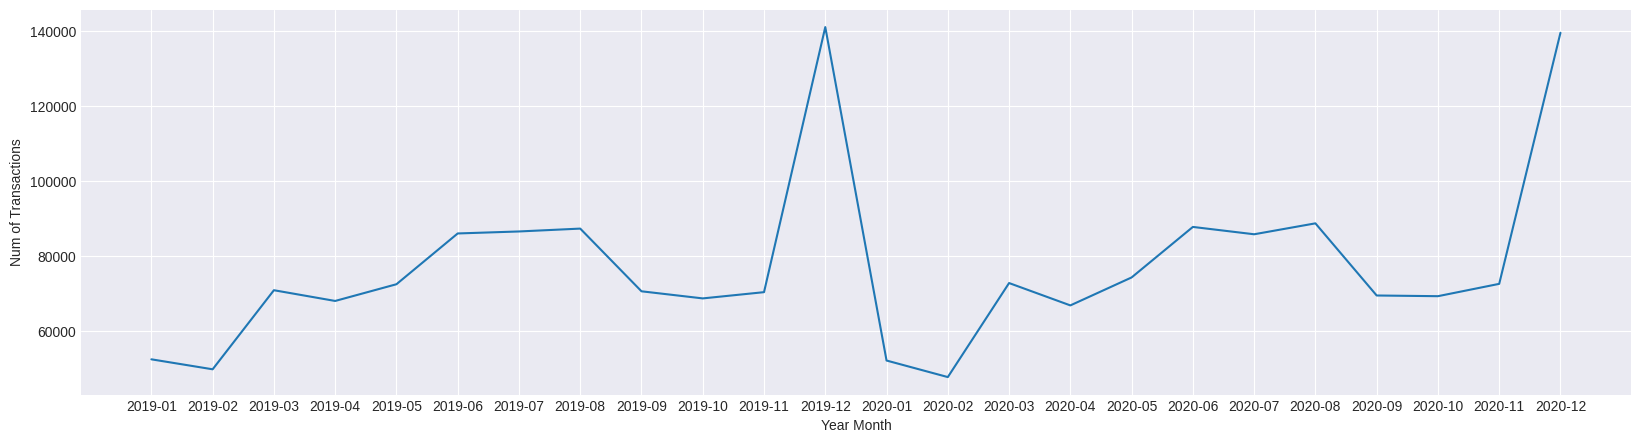

In [21]:
x = np.arange(0,len(df_timeline01),1)

fig, ax = plt.subplots(1,1,figsize=(20,5))
ax.plot(x,df_timeline01['num_of_transactions'])
ax.set_xticks(x)
ax.set_xticklabels(df_timeline01['year_month'])

ax.set_xlabel('Year Month')
ax.set_ylabel('Num of Transactions')
plt.show()

year_month против мошеннических транзакций и мошеннических клиентов

In [22]:
df_fraud_transactions = df[df['is_fraud']==1]

df_timeline02 = df_fraud_transactions.groupby(df_fraud_transactions['trans_year_month'])[['trans_num','cc_num']].nunique().reset_index()
df_timeline02.columns = ['year_month','num_of_fraud_transactions','fraud_customers']
df_timeline02

,year_month,num_of_fraud_transactions,fraud_customers
0,2019-01,506,50
1,2019-02,517,53
2,2019-03,494,49
3,2019-04,376,41
4,2019-05,408,42
5,2019-06,354,35
6,2019-07,331,36
7,2019-08,382,39
8,2019-09,418,44
9,2019-10,454,50


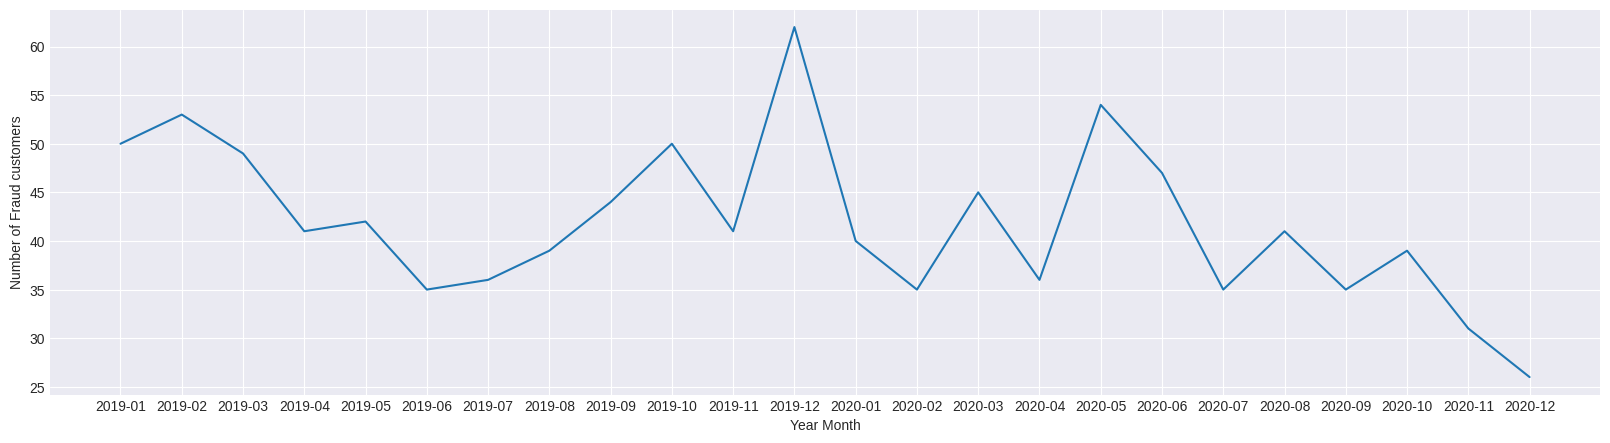

In [23]:
x = np.arange(0,len(df_timeline02),1)

fig, ax = plt.subplots(1,1,figsize=(20,5))
ax.plot(x,df_timeline02['fraud_customers'])
ax.set_xticks(x)
ax.set_xticklabels(df_timeline02['year_month'])

ax.set_xlabel('Year Month')
ax.set_ylabel('Number of Fraud customers')
plt.show()

Из приведенных выше визуализаций можно сделать вывод, что наибольшее количество транзакций произошло во второй половине дня, то есть после 12 часов дня.
Кроме того, большинство транзакций, согласно данным "trans_week", произошли в будние дни недели "воскресенье" и "понедельник".
Более того, согласно данным "trans_year_month", большинство транзакций произошло в январе, феврале, октябре, декабре 2019 года и в мае 2020 года.
Также можно отметить, что количество клиентов-мошенников и количество мошеннических транзакций увеличились в декабре, который снова приходится на сезон отпусков.

Можно заметить, что, поскольку большая часть транзакций происходит после полудня, наблюдение может быть усилено за транзакциями после 12 часов дня, чтобы уменьшить количество мошеннических транзакций.
В праздничные дни, такие как 12 декабря, количество транзакций увеличивается, за таким временем можно внимательно следить, чтобы уменьшить количество мошеннических транзакций.
Кроме того, в сезон отпусков большинство людей, как правило, отправляются за покупками и на другие развлекательные и культурные мероприятия, во время которых люди могут использовать свои кредитные карты для различных целей. И, следовательно, продавцы в таком домене могут быть проверены и проинформированы о происходящих мошеннических действиях.

**Gender**

Теперь давайте рассмотрим гендерный признак в сравнении с признаком is_fraud

In [25]:
#Создадим датафрейм
df_gender = df[['gender','trans_num']].groupby(['gender']).count().reset_index()
df_gender.columns = ['Gender', 'gender_count']

df_fraud_gender = df[['gender','trans_num', 'is_fraud']].groupby(['gender','is_fraud']).count().reset_index()
df_fraud_gender.columns = ['Gender', 'is_fraud', 'Transaction Count']

df_fraud_gender = df_fraud_gender.merge(df_gender[['Gender', 'gender_count']], how='inner', on='Gender')

df_fraud_gender['Transaction percentage'] = (df_fraud_gender['Transaction Count']/df_fraud_gender['gender_count'])*100

df_fraud_gender

,Gender,is_fraud,Transaction Count,gender_count,Transaction percentage
0,F,0,1009850,1014749,99.517221
1,F,1,4899,1014749,0.482779
2,M,0,832893,837645,99.432695
3,M,1,4752,837645,0.567305


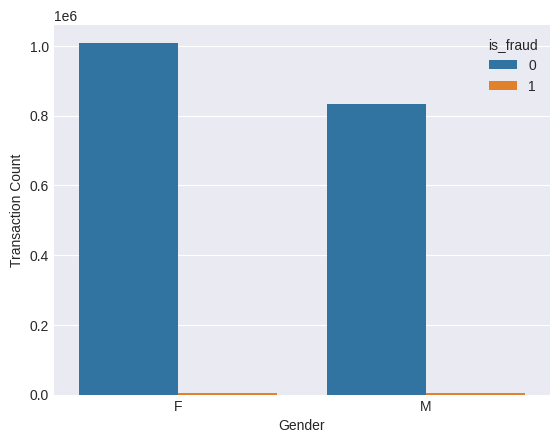

In [26]:
sns.barplot(data=df_fraud_gender, y='Transaction Count', x='Gender', hue='is_fraud')

plt.show()

Из приведенной выше визуализации можно заметить, что женщины вносят наибольший вклад в количество транзакций.
Хотя женщины действительно участвуют в мошенничестве, доля женщин, вовлеченных в мошенничество, по отношению к количеству сделок с участием женщин составляет 0,52%, тогда как аналогичный показатель для мужчин составляет около 0,64%.

Можно сделать вывод, что женщины участвуют в большинстве сделок и, следовательно, они более склонны к мошенничеству.
Таким образом, хотя необходимо, чтобы представители всех полов в данных были осведомлены о мошенничестве и его методах, связанных с кредитными картами, чтобы уменьшить количество мошенничеств, женщины должны быть образованы и обучены быть немного более бдительными, поскольку они гораздо более склонны к мошенничеству.
Можно сделать вывод, что мужчины несколько более склонны к мошенничеству, хотя оба пола, по-видимому, почти в равной степени вовлечены во все мошеннические операции.

**Age**

Давайте теперь построим график зависимости возраста переменной от количества транзакций.
Этот график даст нам общее представление о количестве транзакций, выполняемых различными возрастными группами в данных.

In [27]:
#Сначала разделим по классам возраст
for i in range(len(df.age)):
  if df.age[i] <= 30:
    df.age[i] = '< 30'
  elif df.age[i] > 30 and df.age[i] <= 45:
    df.age[i] = '30-45'
  elif df.age[i] > 45 and df.age[i] <= 60:
    df.age[i] = '46-60'
  elif df.age[i] > 60 and df.age[i] <= 75:
    df.age[i] = '61-75'
  else:
    df.age[i] = '> 75'

df.age.head()

0    30-45
1    30-45
2    46-60
3    46-60
4    30-45
Name: age, dtype: object

Теперь давайте рассмотрим фичу "возраст" относительно переменной "is_fraud".

In [29]:
#Построение распределения количества транзакций по возрасту
df_age = df[['age','trans_num']].groupby(['age']).count().reset_index()
df_age.columns = ['age', 'age_count']

#Создание распределения по возрастному мошенничеству
df_fraud_age = df[['age', 'trans_num', 'is_fraud']].groupby(['age','is_fraud']).count().reset_index()
df_fraud_age.columns = ['age', 'is_fraud', 'Transaction count']

df_fraud_age = df_fraud_age.merge(df_age[['age', 'age_count']], how='inner', on='age')

df_fraud_age['Transaction percentage'] = (df_fraud_age['Transaction count']/df_fraud_age['age_count'])*100

df_fraud_age

,age,is_fraud,Transaction count,age_count,Transaction percentage
0,30-45,0,624194,626681,99.603147
1,30-45,1,2487,626681,0.396853
2,46-60,0,481947,484709,99.430174
3,46-60,1,2762,484709,0.569826
4,61-75,0,250757,252266,99.401822
5,61-75,1,1509,252266,0.598178
6,< 30,0,355435,357316,99.473575
7,< 30,1,1881,357316,0.526425
8,> 75,0,130410,131422,99.229961
9,> 75,1,1012,131422,0.770039


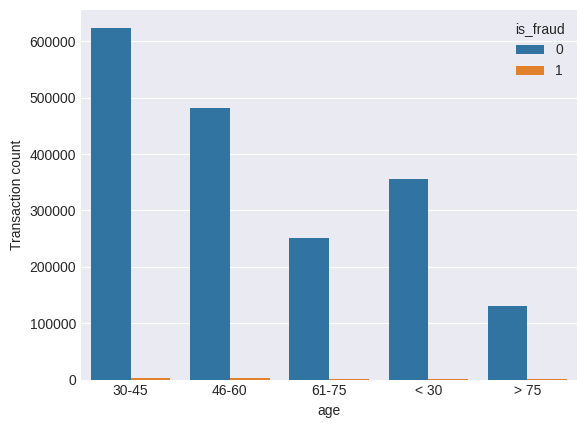

In [30]:
sns.barplot(data=df_fraud_age, y='Transaction count', x='age', hue='is_fraud')

plt.show()

Из приведенных выше графиков можно заметить, что наибольшее количество транзакций в datset было совершено людьми в возрастной группе 30-45 лет.
Кроме того, возрастная группа 46-60 лет совершила значительное количество транзакций.
Что касается общего количества транзакций, совершенных определенной возрастной группой, то больше всего пострадали люди в возрасте > 75 лет, при этом около 1% транзакций, совершенных этими людьми, были мошенническими.

Это люди, которые в значительной степени подвержены мошенничеству, и, следовательно, за их транзакциями нужно следить с гораздо большей бдительностью. Они должны быть информированы о способах мошенничества, чтобы сократить количество мошеннических транзакций.
Мошенники могут вопсользоваться незнанием пожилых людей в области финансовой безопасности в интернете.

**State**

In [31]:
df.state.nunique()

51

Поскольку в столбце "State" содержится множество категорий, сейчас мы рассмотрим только 20 состояний, в которых частота транзакций самая высокая.

In [32]:
#Выбираем 20-ку лучших кандидатов
high_trans_states = df.state.value_counts().head(20).index.tolist()
print(high_trans_states)

['TX', 'NY', 'PA', 'CA', 'OH', 'MI', 'IL', 'FL', 'AL', 'MO', 'MN', 'AR', 'NC', 'VA', 'WI', 'SC', 'KY', 'IN', 'IA', 'OK']


In [33]:
100*df[df.state.isin(high_trans_states)].state.value_counts(normalize=True)

TX   10.961858
NY    9.677414
PA    9.252292
CA    6.523111
OH    5.399284
MI    5.334292
IL    5.041503
FL    4.925052
AL    4.742394
MO    4.449281
MN    3.681776
AR    3.615163
NC    3.495470
VA    3.383801
WI    3.382342
SC    3.381775
KY    3.320997
IN    3.204141
IA    3.144578
OK    3.083476
Name: state, dtype: float64

Теперь давайте посмотрим на распределение fraud с state:

In [35]:
#Построение распределения количества штатов и транзакций
df_state = df[['state','trans_num']].groupby(['state']).count().reset_index()
df_state.columns = ['state', 'state_count']

#Строим отношение state-fraud
df_fraud_state = df[['state', 'trans_num', 'is_fraud']].groupby(['state','is_fraud']).count().reset_index()
df_fraud_state.columns = ['state', 'is_fraud', 'Transaction count']

df_fraud_state = df_fraud_state.merge(df_state[['state', 'state_count']], how='inner', on='state')

df_fraud_state['Transaction percentage'] = (df_fraud_state['Transaction count']/df_fraud_state['state_count'])*100

#Смотрим на 20 из них
df_fraud_state[df_fraud_state['is_fraud'] == 1].sort_values(by = ['Transaction percentage'], ascending=False).head(20)

,state,is_fraud,Transaction count,state_count,Transaction percentage
16,DE,1,9,9,100.000000
78,RI,1,15,745,2.013423
1,AK,1,50,2963,1.687479
74,OR,1,197,26408,0.745986
60,NH,1,79,11727,0.673659
90,VA,1,273,41756,0.653798
84,TN,1,159,24913,0.638221
58,NE,1,216,34425,0.627451
46,MN,1,280,45433,0.616292
68,NY,1,730,119419,0.611293


In [ ]:
print('state with more than 75% fraudulent transactions:\n')
print(df_fraud_state.loc[(df_fraud_state.is_fraud == 1) & (df_fraud_state['Transaction percentage'] >= 75)].state)

В штатах "PA", "TX", "NY" отмечено наибольшее количество транзакций в данном наборе данных.
Следующими по величине в списке являются "FL", "CA", "MI", "AL", "OH" и "IL".
Большинство транзакций происходит в этих штатах, и, следовательно, существует высокая вероятность совершения мошеннических транзакций в этих штатах с помощью различных методов, включая подделку банкоматов и POS-автоматов.
В топ-20 штатов с высокими объемами транзакций можно отметить, что во всех штатах доля мошеннических транзакций составляет около 0,5%.
"DE" - самый мошеннический штат:)

**City и Zip**

In [37]:
print('number of cities: ',df.city.nunique())
print('number of zip codes: ',df.zip.nunique())

number of cities:  906
number of zip codes:  985


Можно заметить, что трудно построить объект с таким большим количеством уникальных значений.
В настоящее время очень высока вероятность мошенничества в городах или почтовых индексах, где очень высока частота транзакций.
Поскольку сложно визуализировать все категории городов одновременно, теперь мы визуализируем 20 городов и 20 почтовых индексов с высокой частотой транзакций.

In [38]:
high_trans_cities = df.city.value_counts().head(20).index.tolist()
high_trans_zips = df.zip.value_counts().head(20).index.tolist()
print('high frequencies cities: ', high_trans_cities)
print('high frequencies zip codes: ', high_trans_zips)

high frequencies cities:  ['Birmingham', 'San Antonio', 'Utica', 'Phoenix', 'Meridian', 'Warren', 'Conway', 'Cleveland', 'Thomas', 'Houston', 'Arcadia', 'Naples', 'Brandon', 'Fulton', 'Indianapolis', 'Burbank', 'Dallas', 'Washington', 'Detroit', 'Hudson']
high frequencies zip codes:  [82514, 73754, 48088, 34112, 61454, 16114, 89512, 72476, 84540, 72042, 33872, 46346, 12419, 29438, 15484, 5461, 85173, 6024, 7060, 58569]


In [ ]:
#Практически аналогично ситуации со штатами
df_city = df[['city','trans_num']].groupby(['city']).count().reset_index()
df_city.columns = ['city', 'city_count']

df_fraud_city = df[['city', 'trans_num', 'is_fraud']].groupby(['city','is_fraud']).count().reset_index()
df_fraud_city.columns = ['city', 'is_fraud', 'Transaction count']

df_fraud_city = df_fraud_city.merge(df_city[['city', 'city_count']], how='inner', on='city')

df_fraud_city['Transaction percentage'] = (df_fraud_city['Transaction count']/df_fraud_city['city_count'])*100

df_fraud_city[df_fraud_city['is_fraud'] == 1].sort_values(by = ['Transaction percentage'], ascending=False).head(20)

In [ ]:
#Тоже самое, только с zip
df_zip = df[['zip','trans_num']].groupby(['zip']).count().reset_index()
df_zip.columns = ['zip', 'zip_count']

df_fraud_zip = df[['zip', 'trans_num', 'is_fraud']].groupby(['zip','is_fraud']).count().reset_index()
df_fraud_zip.columns = ['zip', 'is_fraud', 'Transaction count']

df_fraud_zip = df_fraud_zip.merge(df_zip[['zip', 'zip_count']], how='inner', on='zip')

df_fraud_zip['Transaction percentage'] = (df_fraud_zip['Transaction count']/df_fraud_zip['zip_count'])*100

df_fraud_zip[df_fraud_zip['is_fraud'] == 1].sort_values(by = ['Transaction percentage'], ascending=False).head(20)

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))

plots = []
#построение графика процента мошеннических транзакций с помощью bins

plots.append(sns.countplot(pd.cut(df_fraud_zip[df_fraud_zip.is_fraud == 1]['Transaction percentage'], bins = 4), ax=plt.subplot(121)))
plots.append(sns.countplot(pd.cut(df_fraud_city[df_fraud_city.is_fraud == 1]['Transaction percentage'], bins = 4), ax=plt.subplot(122)))

plots[0].set_title('ZIP')
plots[1].set_title('City')

for plot in plots:
  plot.set_xticklabels(plot.get_xticklabels(), rotation=90)

plt.show()

In [ ]:
#города и почтовые индексы с большим количеством мошеннических транзакций
print('Cities with more than 75% fraudulent transactions:\n')
print(df_fraud_city.loc[(df_fraud_city.is_fraud == 1) & (df_fraud_city['Transaction percentage'] >= 75)].city.tolist())
print('\n\nZip codes with more than 75% fraudulent transactions:\n')
print(df_fraud_zip.loc[(df_fraud_zip.is_fraud == 1) & (df_fraud_zip['Transaction percentage'] >= 75)].zip.tolist())

На приведенном выше графике можно увидеть места с высокой частотой транзакций.
общеизвестно, что эти почтовые индексы и города являются одними из самых оживленных мест в мире, что оправдывает частоту транзакций в этих районах.
примерно на 50 почтовых индексов и 70 городов приходится более 75% мошеннических транзакций.

**Job**

In [40]:
df.job.nunique()

497

Схожая ситуация с городами и индексами с количеством уникальных значений. Возьмем также 20-ку:

In [41]:
high_trans_jobs = df.job.value_counts().head(20).index.tolist()
print(high_trans_jobs)

['Film/video editor', 'Exhibition designer', 'Surveyor, land/geomatics', 'Naval architect', 'Materials engineer', 'Designer, ceramics/pottery', 'Environmental consultant', 'Financial adviser', 'Systems developer', 'IT trainer', 'Copywriter, advertising', 'Scientist, audiological', 'Chartered public finance accountant', 'Chief Executive Officer', 'Podiatrist', 'Comptroller', 'Magazine features editor', 'Agricultural consultant', 'Paramedic', 'Sub']


In [52]:
df_job = df[['job','trans_num']].groupby(['job']).count().reset_index()
df_job.columns = ['job', 'job_count']

df_fraud_job = df[['job', 'trans_num', 'is_fraud']].groupby(['job','is_fraud']).count().reset_index()
df_fraud_job.columns = ['job', 'is_fraud', 'Transaction count']

df_fraud_job = df_fraud_job.merge(df_job[['job', 'job_count']], how='inner', on='job')

df_fraud_job['Transaction percentage'] = (df_fraud_job['Transaction count']/df_fraud_job['job_count'])*100

df_fraud_job[df_fraud_job['is_fraud'] == 1].sort_values(by = ['Transaction percentage'], ascending=False).head(20)

,job,is_fraud,Transaction count,job_count,Transaction percentage
444,Homeopath,1,11,11,100.000000
2,"Accountant, chartered",1,11,11,100.000000
393,Forest/woodland manager,1,9,9,100.000000
834,Software engineer,1,11,11,100.000000
827,Ship broker,1,7,7,100.000000
68,Armed forces technical officer,1,8,8,100.000000
228,Dancer,1,19,19,100.000000
796,Sales promotion account executive,1,14,14,100.000000
39,Air traffic controller,1,17,17,100.000000
99,Broadcast journalist,1,9,9,100.000000


In [54]:
#Работы с более чем одним процентом мошеннических транзакций
df_fraud_job.loc[(df_fraud_job.is_fraud == 1) & (df_fraud_job['Transaction percentage'] >= 50)].job

2                  Accountant, chartered
39                Air traffic controller
68        Armed forces technical officer
99                  Broadcast journalist
118                      Careers adviser
207           Contracting civil engineer
228                               Dancer
335                       Engineer, site
340                      Engineer, water
393              Forest/woodland manager
444                            Homeopath
475                     Industrial buyer
478                  Information officer
521                      Legal secretary
624        Operational investment banker
651                    Personnel officer
796    Sales promotion account executive
827                          Ship broker
834                    Software engineer
837                            Solicitor
947                   Veterinary surgeon
956                    Warehouse manager
Name: job, dtype: object

Выше приведены работы, в которых была отмечена высокая частота транзакций.

Люди, работающие на должностях с большим количеством мошеннических транзакций, могут быть предупреждены о мошенничестве с кредитными картами, чтобы они могли быть более осторожными при использовании своих кредитных карт.
рабочие роли, в которых почти все транзакции являются мошенническими, могут означать, что в точке данных произошла какая-то ошибка. То есть, лицо, представляющее конкретную работу, может быть виновато, поскольку крайне маловероятно, что все транзакции, совершенные лицом с конкретной работы, являются мошенническими. Следовательно, в этом случае может помочь своего рода проверка биографических данных пользователя кредитной карты.

**Category**

In [43]:
df.category.value_counts(normalize=True)

gas_transport    0.101506
grocery_pos      0.095115
home             0.094721
shopping_pos     0.089864
kids_pets        0.087307
shopping_net     0.075212
entertainment    0.072403
food_dining      0.070573
personal_care    0.070225
health_fitness   0.066159
misc_pos         0.061666
misc_net         0.048939
grocery_net      0.035024
travel           0.031287
Name: category, dtype: float64

In [45]:
df_category = df[['category','trans_num']].groupby(['category']).count().reset_index()
df_category.columns = ['category', 'category_count']

df_fraud_category = df[['category', 'trans_num', 'is_fraud']].groupby(['category','is_fraud']).count().reset_index()
df_fraud_category.columns = ['category', 'is_fraud', 'Transaction count']

df_fraud_category = df_fraud_category.merge(df_category[['category', 'category_count']], how='inner', on='category')

df_fraud_category['Transaction percentage'] = (df_fraud_category['Transaction count']/df_fraud_category['category_count'])*100

df_fraud_category[df_fraud_category['is_fraud'] == 1].sort_values(by = ['Transaction percentage'], ascending=False)

,category,is_fraud,Transaction count,category_count,Transaction percentage
23,shopping_net,1,2219,139322,1.592713
17,misc_net,1,1182,90654,1.303859
9,grocery_pos,1,2228,176191,1.264537
25,shopping_pos,1,1056,166463,0.634375
5,gas_transport,1,772,188029,0.410575
19,misc_pos,1,322,114229,0.281890
7,grocery_net,1,175,64878,0.269737
27,travel,1,156,57956,0.269170
21,personal_care,1,290,130085,0.222931
1,entertainment,1,292,134118,0.217719


In [58]:
df_fraud_category.loc[(df_fraud_category.is_fraud == 1) & (df_fraud_category['Transaction percentage'] >= 1)].category

9      grocery_pos
17        misc_net
23    shopping_net
Name: category, dtype: object

In [59]:
df_fraud_category.head()

,category,is_fraud,Transaction count,category_count,Transaction percentage
0,entertainment,0,133826,134118,99.782281
1,entertainment,1,292,134118,0.217719
2,food_dining,0,130524,130729,99.843187
3,food_dining,1,205,130729,0.156813
4,gas_transport,0,187257,188029,99.589425


Из приведенных выше графиков и созданных фреймов данных можно заметить, что примерно в 3 категориях мошеннических транзакций задействовано более 1%. Это - grocery_pos, misc_net, shopping_net.
Из них наибольшее количество мошеннических транзакций приходится на категорию shopping_net.

**Merchant**

In [47]:
df.merchant.nunique()

693

Мы будем анализировать только продавцов с наибольшим количеством мошеннических транзакций

In [48]:
high_trans_merchants = df.merchant.value_counts().head(20).index.tolist()
high_trans_merchants

['fraud_Kilback LLC',
 'fraud_Cormier LLC',
 'fraud_Schumm PLC',
 'fraud_Kuhn LLC',
 'fraud_Boyer PLC',
 'fraud_Dickinson Ltd',
 'fraud_Emard Inc',
 'fraud_Cummerata-Jones',
 'fraud_Corwin-Collins',
 'fraud_Rodriguez Group',
 'fraud_Kling Inc',
 'fraud_Parisian and Sons',
 'fraud_Erdman-Kertzmann',
 'fraud_Huels-Hahn',
 'fraud_Stroman, Hudson and Erdman',
 'fraud_Kutch LLC',
 'fraud_Jenkins, Hauck and Friesen',
 'fraud_Prohaska-Murray',
 'fraud_Olson, Becker and Koch',
 'fraud_Eichmann, Bogan and Rodriguez']

In [61]:
df_merchant = df[['merchant','trans_num']].groupby(['merchant']).count().reset_index()
df_merchant.columns = ['merchant', 'merchant_count']

df_fraud_merchant = df[['merchant', 'trans_num', 'is_fraud']].groupby(['merchant','is_fraud']).count().reset_index()
df_fraud_merchant.columns = ['merchant', 'is_fraud', 'Transaction count']

df_fraud_merchant = df_fraud_merchant.merge(df_merchant[['merchant', 'merchant_count']], how='inner', on='merchant')

df_fraud_merchant['Transaction percentage'] = (df_fraud_merchant['Transaction count']/df_fraud_merchant['merchant_count'])*100

df_fraud_merchant[df_fraud_merchant['is_fraud'] == 1].sort_values(by = ['Transaction percentage'], ascending=False).head(20)

,merchant,is_fraud,Transaction count,merchant_count,Transaction percentage
673,fraud_Kozey-Boehm,1,60,2758,2.175489
490,"fraud_Herman, Treutel and Dickens",1,38,1870,2.032086
1226,fraud_Terry-Huel,1,56,2864,1.955307
607,fraud_Kerluke-Abshire,1,50,2635,1.897533
884,"fraud_Mosciski, Ziemann and Farrell",1,53,2821,1.878766
1105,"fraud_Schmeler, Bashirian and Price",1,52,2788,1.865136
691,fraud_Kuhic LLC,1,53,2842,1.864884
563,fraud_Jast Ltd,1,51,2757,1.849837
743,"fraud_Langworth, Boehm and Gulgowski",1,52,2817,1.845935
1051,"fraud_Romaguera, Cruickshank and Greenholt",1,51,2767,1.843151


In [63]:
len(df_fraud_merchant.loc[(df_fraud_merchant.is_fraud == 1) & (df_fraud_merchant['Transaction percentage'] >= 1)].merchant)

139

In [64]:
df_fraud_merchant.loc[(df_fraud_merchant.is_fraud == 1) & (df_fraud_merchant['Transaction percentage'] >= 2)].merchant

490    fraud_Herman, Treutel and Dickens
673                    fraud_Kozey-Boehm
Name: merchant, dtype: object

Из приведенных выше графиков и созданных фреймов данных можно заметить, что примерно у 140 продавцов более 1% транзакций ассоциируются с ними как мошеннические.

Теперь, когда мы закончили с процессом EDA, приступим к созданию фиктивных переменных и кодированию фич там, где это требуется в нашем наборе данных.

**Feature Encoding**

In [65]:
category_onehot = pd.get_dummies(df.category, prefix='category', drop_first=True)
gender_onehot = pd.get_dummies(df.gender, prefix='gender', drop_first=True)
day_of_week_onehot = pd.get_dummies(df.trans_day_of_week, prefix='day', drop_first=True)
age_onehot = pd.get_dummies(df.age, prefix='age', drop_first=True)

In [66]:
df1 = pd.concat([df, category_onehot,gender_onehot,day_of_week_onehot,age_onehot], axis=1)

df1.head()

,cc_num,merchant,category,amt,gender,street,city,state,zip,lat,long,city_pop,job,trans_num,unix_time,merch_lat,merch_long,is_fraud,trans_hour,trans_day_of_week,trans_year_month,age,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,gender_M,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,age_46-60,age_61-75,age_< 30,age_> 75
0,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.970000,F,561 Perry Cove,Moravian Falls,NC,28654,36.078800,-81.178100,3495,"Psychologist, counselling",0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,0,Tuesday,2019-01,30-45,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.230000,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.887800,-118.210500,149,Special educational needs teacher,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,0,Tuesday,2019-01,30-45,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,38859492057661,fraud_Lind-Buckridge,entertainment,220.110000,M,594 White Dale Suite 530,Malad City,ID,83252,42.180800,-112.262000,4154,Nature conservation officer,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,0,Tuesday,2019-01,46-60,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0
3,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.000000,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.230600,-112.113800,1939,Patent attorney,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,0,Tuesday,2019-01,46-60,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0
4,375534208663984,fraud_Keeling-Crist,misc_pos,41.960000,M,408 Bradley Rest,Doe Hill,VA,24433,38.420700,-79.462900,99,Dance movement psychotherapist,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,0,Tuesday,2019-01,30-45,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0


Теперь некоторые функции, такие как 'cc_num', 'first', 'last', 'trans_num', не являются значимыми в контексте нашего анализа и, следовательно, могут быть удалены.

In [67]:
df1.drop([ 'cc_num', 'trans_num'], axis=1, inplace=True)
print(df1.shape)
df1.columns

(1852394, 44)


Index(['merchant', 'category', 'amt', 'gender', 'street', 'city', 'state',
       'zip', 'lat', 'long', 'city_pop', 'job', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud', 'trans_hour', 'trans_day_of_week',
       'trans_year_month', 'age', 'category_food_dining',
       'category_gas_transport', 'category_grocery_net',
       'category_grocery_pos', 'category_health_fitness', 'category_home',
       'category_kids_pets', 'category_misc_net', 'category_misc_pos',
       'category_personal_care', 'category_shopping_net',
       'category_shopping_pos', 'category_travel', 'gender_M', 'day_Monday',
       'day_Saturday', 'day_Sunday', 'day_Thursday', 'day_Tuesday',
       'day_Wednesday', 'age_46-60', 'age_61-75', 'age_< 30', 'age_> 75'],
      dtype='object')

В приведенном выше фрейме данных df1 функция "merchant" может быть удалена, поскольку у нее много уникальных значений, и их трудно закодировать все. И то же самое относится к переменным - "улица", "город", "штат" и "работа"
Аналогично, переменные - 'age', 'category', 'gender', 'trans_day_of_week' также могут быть удалены, поскольку они уже были закодированы.

In [68]:
df1.drop(['merchant','street','city','state','job',
          'category','gender','trans_day_of_week',
          'age'],axis=1, inplace=True)
df1.columns

Index(['amt', 'zip', 'lat', 'long', 'city_pop', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud', 'trans_hour', 'trans_year_month',
       'category_food_dining', 'category_gas_transport',
       'category_grocery_net', 'category_grocery_pos',
       'category_health_fitness', 'category_home', 'category_kids_pets',
       'category_misc_net', 'category_misc_pos', 'category_personal_care',
       'category_shopping_net', 'category_shopping_pos', 'category_travel',
       'gender_M', 'day_Monday', 'day_Saturday', 'day_Sunday', 'day_Thursday',
       'day_Tuesday', 'day_Wednesday', 'age_46-60', 'age_61-75', 'age_< 30',
       'age_> 75'],
      dtype='object')

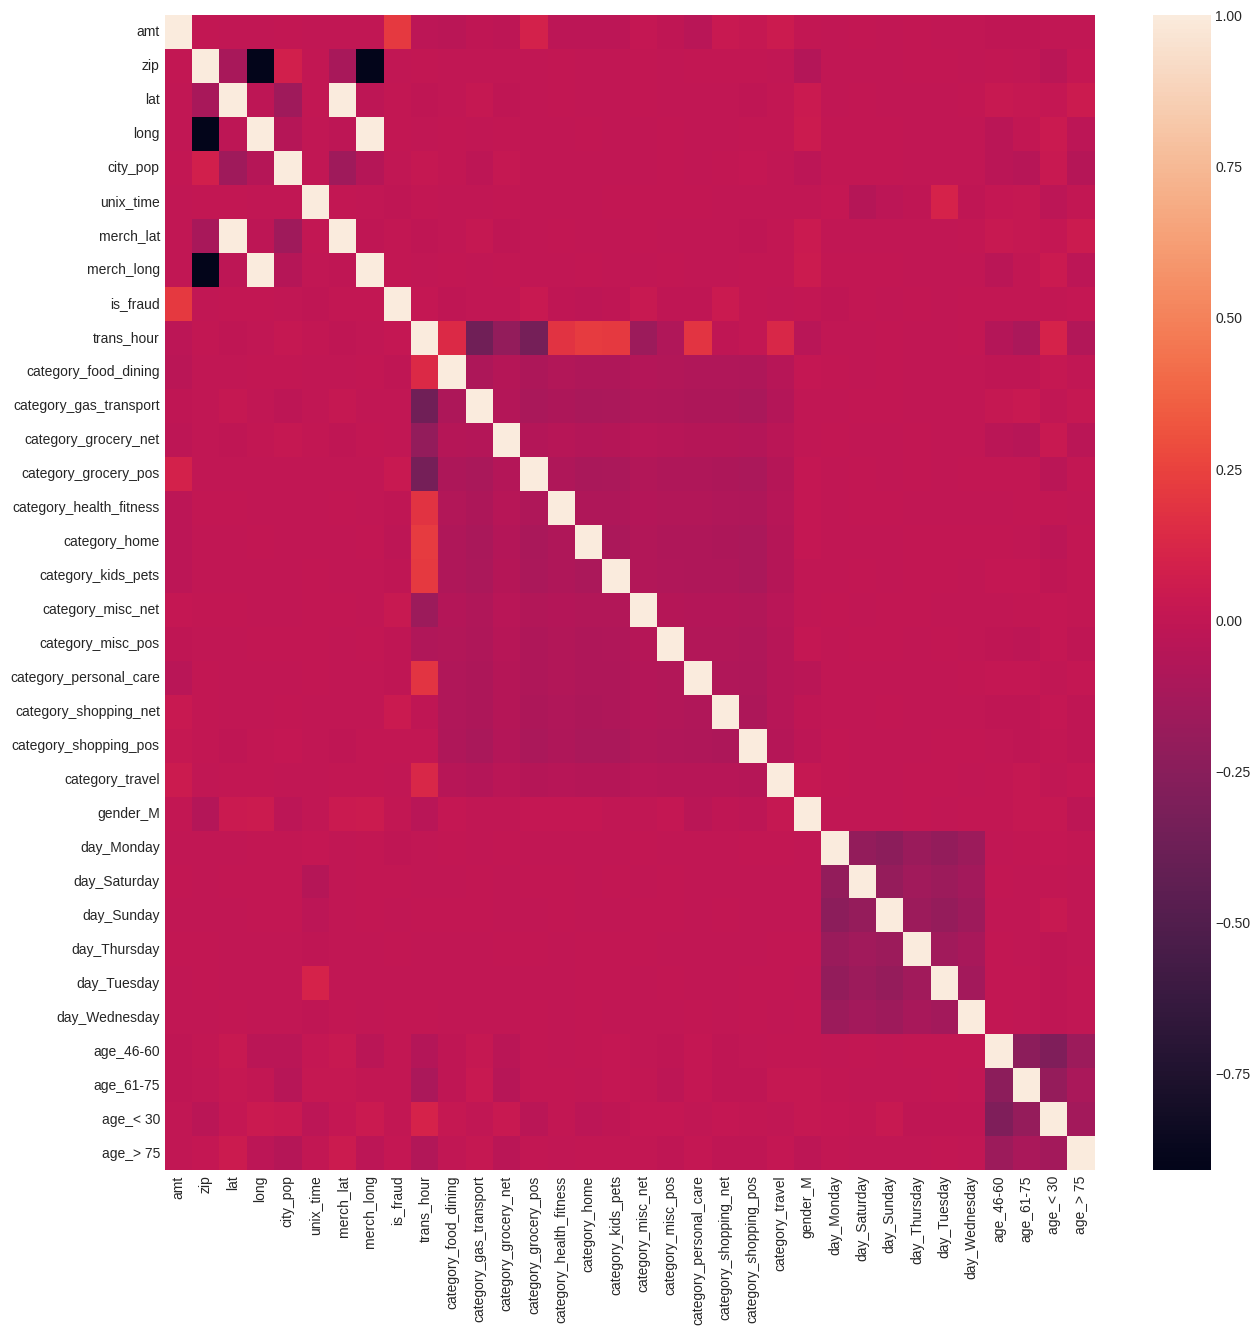

In [69]:
#Посмотрим на корреляцию
df_random_under_corr = df1.corr()

plt.figure(figsize=(15,15))
sns.heatmap(df_random_under_corr)
plt.show()

Теперь, поскольку переменных много, давайте получим переменные с высокой корреляцией, используя функцию, которая выводит переменные с корреляцией между ними выше определенного порога.

In [70]:
def correlation(dataset, threshold):
    col_corr = set() # В этом наборе хранятся столбцы с высокой степенью корреляции
    corr_matrix = dataset.corr() #Матрица корреляции
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if corr_matrix.iloc[i,j] > threshold:
                colname = corr_matrix.columns[i] #Выбираем столбцы выше порога
                col_corr.add(colname) #Добавляем их
    return col_corr

In [71]:
#Установим порог в 85%
corr_features = correlation(df1,0.85)
corr_features

{'merch_lat', 'merch_long'}

Как видно, нет признаков, корреляция которых превышала бы 85%. Следовательно, можно смело приступать к построению модели.

**Алгоритмы**

In [72]:
#Сохранение количества значений в каждом классе
non_fraud_count, fraud_count = df1.is_fraud.value_counts()

In [73]:
#Сохранение числовых столбцов данных и удаление ненужных переменных
df_num = df1.select_dtypes(include='number')
df_num.drop(['zip', 'lat', 'long', 'city_pop', 'unix_time', 'merch_lat','merch_long'],
            axis=1, inplace=True)
df_num.columns

Index(['amt', 'is_fraud', 'trans_hour', 'category_food_dining',
       'category_gas_transport', 'category_grocery_net',
       'category_grocery_pos', 'category_health_fitness', 'category_home',
       'category_kids_pets', 'category_misc_net', 'category_misc_pos',
       'category_personal_care', 'category_shopping_net',
       'category_shopping_pos', 'category_travel', 'gender_M', 'day_Monday',
       'day_Saturday', 'day_Sunday', 'day_Thursday', 'day_Tuesday',
       'day_Wednesday', 'age_46-60', 'age_61-75', 'age_< 30', 'age_> 75'],
      dtype='object')

In [74]:
df_num.head(5)

,amt,is_fraud,trans_hour,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,gender_M,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,age_46-60,age_61-75,age_< 30,age_> 75
0,4.970000,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,107.230000,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,220.110000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0
3,45.000000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0
4,41.960000,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0


In [75]:
df_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 27 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   amt                      float64
 1   is_fraud                 int64  
 2   trans_hour               int64  
 3   category_food_dining     uint8  
 4   category_gas_transport   uint8  
 5   category_grocery_net     uint8  
 6   category_grocery_pos     uint8  
 7   category_health_fitness  uint8  
 8   category_home            uint8  
 9   category_kids_pets       uint8  
 10  category_misc_net        uint8  
 11  category_misc_pos        uint8  
 12  category_personal_care   uint8  
 13  category_shopping_net    uint8  
 14  category_shopping_pos    uint8  
 15  category_travel          uint8  
 16  gender_M                 uint8  
 17  day_Monday               uint8  
 18  day_Saturday             uint8  
 19  day_Sunday               uint8  
 20  day_Thursday             uint8  
 21  day_Tues

In [76]:
df_num.to_csv('processed.csv')

In [77]:
#innput-output разделение
X = df_num.drop(['is_fraud'],axis=1)
y = df_num.is_fraud

In [78]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

**Logistic Regression**

In [79]:
#train-test split using stratified K fold
skf = StratifiedKFold(n_splits=2)
skf.get_n_splits(X,y)

for train_index, test_index in skf.split(X,y):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

y_train.value_counts()

0    921372
1      4825
Name: is_fraud, dtype: int64

Как можно видеть, классы в целевой переменной являются несбалансированными. Нам нужно исправить это позже.

In [80]:
lr = LogisticRegression(random_state=42)
model = lr.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('y_train_pred: ',y_train_pred)
y_test_pred = model.predict(X_test)
print('y_test_pred: ', y_test_pred)

y_train_pred:  [0 0 0 ... 0 0 0]
y_test_pred:  [0 0 0 ... 0 0 0]


In [81]:
model_name = 'Logistic Regression - without balancing'
train_score = model.score(X_train,y_train)
test_score = model.score(X_test,y_test)

acc_score = accuracy_score(y_test,y_test_pred)
f_score = f1_score(y_test, y_test_pred, average='weighted')
precision = precision_score(y_test, y_test_pred)
recall = metrics.recall_score(y_test,y_test_pred)
#Создадим датафрейм, куда будет заносить результаты работы различных моделей
model_eval_data = [[model_name, train_score, test_score, acc_score, f_score, precision, recall]]
evaluate_df = pd.DataFrame(model_eval_data, columns=['Model Name', 'Training Score', 'Testing Score', 'Accuracy',
                                          'F1 Score', 'Precision', 'Recall'])
evaluate_df

,Model Name,Training Score,Testing Score,Accuracy,F1 Score,Precision,Recall
0,Logistic Regression - without balancing,0.994443,0.994430,0.994430,0.992031,0.028329,0.002072


Из приведенного выше фрейма данных видно, что, хотя мы не сбалансировали классы в нашей целевой переменной, точность и несколько других показателей, похоже, выглядят отлично.

Это связано с тем, что, поскольку на данный момент в наборе данных нет баланса, модель прогнозирует почти все точки данных как "не мошеннические".
Это явно не удовлетворяет нашей цели, следовательно, нам нужно сбалансировать классы в целевой переменной, чтобы построить "справедливую" модель.

Будем использовать только X_train и y_train, полученные из StratifiedKFold, которое мы получили выше, и использовать X_test и y_test для тестирования наших моделей на данных.
Мы также будем балансировать только точки данных в наборах X_train и y_train и тестировать модель на несбалансированных данных X_test и y_test.
Следовательно, мы сохраним X_test и y_test как test_input и test_output для лучшего понимания.

In [82]:
#Переназовем
test_input = X_test.copy()
test_output = y_test.copy()

test_output.value_counts(normalize=True)

0   0.994789
1   0.005211
Name: is_fraud, dtype: float64

In [83]:
#Сохраняем все мошеннические транзакции
fraud_trans = df_num[df_num['is_fraud'] == 1]
non_fraud_trans = df_num[df_num['is_fraud'] == 0]

print('fraud data shape: ', fraud_trans.shape)
print('non fraud data shape: ', non_fraud_trans.shape)

#Выводим их в процентах
print('Fraud Data percentage: ', 100*(len(fraud_trans)/len(non_fraud_trans)))

fraud data shape:  (9651, 27)
non fraud data shape:  (1842743, 27)
Fraud Data percentage:  0.5237301132062366


Из приведенного выше шага можно заметить, что фрейм данных сильно несбалансирован.

Количество мошеннических транзакций составляет всего около 0,5% от общего объема данных.

Этот дисбаланс может привести к смещению в процессе построения нашей модели.
Следовательно, нам придется сбалансировать набор данных, выполнив избыточную или недостаточную выборку.

**Undersampling - Random Undersampling:**

Для этого мы будем использовать метод выборки, чтобы случайным образом выбрать общее количество точек данных из класса большинства, как и в классе меньшинства.

In [84]:
rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_resample(X_train,y_train)

y_rus.value_counts()

0    4825
1    4825
Name: is_fraud, dtype: int64

In [85]:
import pickle as pic

In [86]:
pic.dump(rus, open('lostic_undersampling.pkl', 'wb'))

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X_rus, y_rus, test_size=0.3, random_state=42, stratify=y_rus)

In [88]:
y_train.value_counts()

1    3378
0    3377
Name: is_fraud, dtype: int64

Давайте теперь построим базовую линейную модель для анализа этих данных после недостаточной выборки:

In [89]:
lr = LogisticRegression(random_state=42)

model = lr.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_train_pred

array([1, 1, 0, ..., 0, 0, 0])

In [90]:
#Прогнозирование на основе несбалансированных тестовых данных
test_pred=model.predict(test_input)
test_pred

array([1, 1, 1, ..., 0, 0, 0])

In [91]:
pic.dump(model, open('lostic_imbalanced.pkl', 'wb'))

In [92]:
#Посмотрим на метрики классификации
print(classification_report(test_output,test_pred))

              precision    recall  f1-score   support

           0       1.00      0.87      0.93    921371
           1       0.03      0.75      0.06      4826

    accuracy                           0.87    926197
   macro avg       0.51      0.81      0.49    926197
weighted avg       0.99      0.87      0.93    926197



In [93]:
#Оценка модели
model_name = 'Logistic Regression - Random Under Sampling'
train_score = model.score(X_train,y_train)
test_score = model.score(X_test,y_test)

acc_score = accuracy_score(test_output,test_pred)
f_score = f1_score(test_output, test_pred, average='weighted')
precision = precision_score(test_output, test_pred)
recall = metrics.recall_score(test_output,test_pred)

model_eval_data = [model_name, train_score, test_score, acc_score, f_score, precision, recall]
model_eval_dict = {evaluate_df.columns[i]:model_eval_data[i] for i in range(len(model_eval_data))}
evaluate_df = evaluate_df.append(model_eval_dict, ignore_index=True)

evaluate_df

,Model Name,Training Score,Testing Score,Accuracy,F1 Score,Precision,Recall
0,Logistic Regression - without balancing,0.994443,0.994430,0.994430,0.992031,0.028329,0.002072
1,Logistic Regression - Random Under Sampling,0.810511,0.811399,0.870296,0.925808,0.029571,0.750932


Из приведенного выше фрейма данных можно отметить, что, хотя accuracy, training и testing score, а также показатели оценки F1 снизились, precision и recall улучшились, что является гораздо более важными показателями для оценки классификационной модели.

**Oversampling - Random Over Sampling:**

In [94]:
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X_train,y_train)

y_ros.value_counts()

1    3378
0    3378
Name: is_fraud, dtype: int64

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X_ros,y_ros, test_size=0.3, stratify=y_ros, random_state=42)
y_train.value_counts()

1    2365
0    2364
Name: is_fraud, dtype: int64

In [96]:
lr = LogisticRegression(random_state=42)

model = lr.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_train_pred

array([0, 0, 1, ..., 0, 0, 1])

In [97]:
test_pred = model.predict(test_input)
test_pred

array([1, 1, 1, ..., 0, 0, 0])

In [98]:
print(classification_report(test_output, test_pred))

              precision    recall  f1-score   support

           0       1.00      0.87      0.93    921371
           1       0.03      0.75      0.06      4826

    accuracy                           0.87    926197
   macro avg       0.51      0.81      0.49    926197
weighted avg       0.99      0.87      0.92    926197



In [99]:
model_name = 'Logistic Regression - Random Over Sampling'
train_score = model.score(X_train,y_train)
test_score = model.score(X_test,y_test)

acc_score = accuracy_score(test_output,test_pred)
f_score = f1_score(test_output, test_pred, average='weighted')
precision = precision_score(test_output, test_pred)
recall = metrics.recall_score(test_output,test_pred)

model_eval_data = [model_name, train_score, test_score, acc_score, f_score, precision, recall]
model_eval_dict = {evaluate_df.columns[i]:model_eval_data[i] for i in range(len(model_eval_data))}
evaluate_df = evaluate_df.append(model_eval_dict, ignore_index=True)

evaluate_df

,Model Name,Training Score,Testing Score,Accuracy,F1 Score,Precision,Recall
0,Logistic Regression - without balancing,0.994443,0.994430,0.994430,0.992031,0.028329,0.002072
1,Logistic Regression - Random Under Sampling,0.810511,0.811399,0.870296,0.925808,0.029571,0.750932
2,Logistic Regression - Random Over Sampling,0.807359,0.812037,0.867825,0.924389,0.029059,0.751761


**Decision Tree**

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

dtree = DecisionTreeClassifier(max_depth=10)

model = dtree.fit(X_train,y_train)

y_test_pred = model.predict(X_test)

print(classification_report(y_test, y_test_pred))

model_name = 'Decision Tree - without balancing'
train_score = model.score(X_train,y_train)
test_score = model.score(X_test,y_test)

acc_score = accuracy_score(y_test,y_test_pred)
f_score = f1_score(y_test, y_test_pred, average='weighted')
precision = precision_score(y_test, y_test_pred)
recall = metrics.recall_score(y_test,y_test_pred)

model_eval_data = [model_name, train_score, test_score, acc_score, f_score, precision, recall]
model_eval_dict = {evaluate_df.columns[i]:model_eval_data[i] for i in range(len(model_eval_data))}
evaluate_df = evaluate_df.append(model_eval_dict, ignore_index=True)

evaluate_df

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552781
           1       0.92      0.75      0.83      2938

    accuracy                           1.00    555719
   macro avg       0.96      0.88      0.91    555719
weighted avg       1.00      1.00      1.00    555719



,Model Name,Training Score,Testing Score,Accuracy,F1 Score,Precision,Recall
0,Logistic Regression - without balancing,0.994443,0.994430,0.994430,0.992031,0.028329,0.002072
1,Logistic Regression - Random Under Sampling,0.810511,0.811399,0.870296,0.925808,0.029571,0.750932
2,Logistic Regression - Random Over Sampling,0.807359,0.812037,0.867825,0.924389,0.029059,0.751761
3,Decision Tree - without balancing,0.998522,0.998348,0.998348,0.998268,0.918046,0.754935


Из вышесказанного можно понять, что деревья принятия решений не могут эффективно обрабатывать несбалансированные данные, что можно наблюдать по показателю отзыва. Следовательно, теперь мы сбалансируем переменную и попробуем еще раз.
Для этого мы можем использовать переменные, которые мы создали выше для различных методов выборки.

DT Undersampling

In [101]:
#train-test split
X_train, X_test, y_train, y_test = train_test_split(X_rus,y_rus, test_size=0.3, random_state=42)

dtree = DecisionTreeClassifier(max_depth=10)

model = dtree.fit(X_train,y_train)

test_pred = model.predict(test_input)

print(classification_report(test_output, test_pred))

#evaluating the model
model_name = 'Decision Tree - Random Under Sampling'
train_score = model.score(X_train,y_train)
test_score = model.score(X_test,y_test)

acc_score = accuracy_score(test_output,test_pred)
f_score = f1_score(test_output, test_pred, average='weighted')
precision = precision_score(test_output, test_pred)
recall = metrics.recall_score(test_output,test_pred)
#adding claculations to dataframe
model_eval_data = [model_name, train_score, test_score, acc_score, f_score, precision, recall]
model_eval_dict = {evaluate_df.columns[i]:model_eval_data[i] for i in range(len(model_eval_data))}
evaluate_df = evaluate_df.append(model_eval_dict, ignore_index=True)

evaluate_df

              precision    recall  f1-score   support

           0       1.00      0.95      0.98    921371
           1       0.10      0.98      0.18      4826

    accuracy                           0.95    926197
   macro avg       0.55      0.97      0.58    926197
weighted avg       1.00      0.95      0.97    926197



,Model Name,Training Score,Testing Score,Accuracy,F1 Score,Precision,Recall
0,Logistic Regression - without balancing,0.994443,0.994430,0.994430,0.992031,0.028329,0.002072
1,Logistic Regression - Random Under Sampling,0.810511,0.811399,0.870296,0.925808,0.029571,0.750932
2,Logistic Regression - Random Over Sampling,0.807359,0.812037,0.867825,0.924389,0.029059,0.751761
3,Decision Tree - without balancing,0.998522,0.998348,0.998348,0.998268,0.918046,0.754935
4,Decision Tree - Random Under Sampling,0.979719,0.965112,0.954147,0.972271,0.100130,0.976585


DT Oversampling

In [102]:
#train-test split
X_train, X_test, y_train, y_test = train_test_split(X_ros,y_ros, test_size=0.3, random_state=42)

dtree = DecisionTreeClassifier(max_depth=10)

model = dtree.fit(X_train,y_train)

test_pred = model.predict(test_input)

print(classification_report(test_output, test_pred))

#evaluating the model
model_name = 'Decision Tree - Random Over Sampling'
train_score = model.score(X_train,y_train)
test_score = model.score(X_test,y_test)

acc_score = accuracy_score(test_output,test_pred)
f_score = f1_score(test_output, test_pred, average='weighted')
precision = precision_score(test_output, test_pred)
recall = metrics.recall_score(test_output,test_pred)
#adding claculations to dataframe
model_eval_data = [model_name, train_score, test_score, acc_score, f_score, precision, recall]
model_eval_dict = {evaluate_df.columns[i]:model_eval_data[i] for i in range(len(model_eval_data))}
evaluate_df = evaluate_df.append(model_eval_dict, ignore_index=True)

evaluate_df

              precision    recall  f1-score   support

           0       1.00      0.96      0.98    921371
           1       0.10      0.96      0.19      4826

    accuracy                           0.96    926197
   macro avg       0.55      0.96      0.58    926197
weighted avg       1.00      0.96      0.97    926197



,Model Name,Training Score,Testing Score,Accuracy,F1 Score,Precision,Recall
0,Logistic Regression - without balancing,0.994443,0.994430,0.994430,0.992031,0.028329,0.002072
1,Logistic Regression - Random Under Sampling,0.810511,0.811399,0.870296,0.925808,0.029571,0.750932
2,Logistic Regression - Random Over Sampling,0.807359,0.812037,0.867825,0.924389,0.029059,0.751761
3,Decision Tree - without balancing,0.998522,0.998348,0.998348,0.998268,0.918046,0.754935
4,Decision Tree - Random Under Sampling,0.979719,0.965112,0.954147,0.972271,0.100130,0.976585
5,Decision Tree - Random Over Sampling,0.989004,0.959546,0.956901,0.973751,0.104713,0.963116


Исходя из вышесказанного, можно заметить, что метод балансировки переменных "Radom Over sampling" наиболее эффективен. И очевидно, что модель дерева решений на данный момент является лучшей моделью.

**Random Forest**

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

rf = RandomForestClassifier(n_estimators=100, criterion='gini')

model = rf.fit(X_train,y_train)

y_test_pred = model.predict(X_test)

print(classification_report(y_test, y_test_pred))

model_name = 'Random Forest - without balancing'
train_score = model.score(X_train,y_train)
test_score = model.score(X_test,y_test)

acc_score = accuracy_score(y_test,y_test_pred)
f_score = f1_score(y_test, y_test_pred, average='weighted')
precision = precision_score(y_test, y_test_pred)
recall = metrics.recall_score(y_test,y_test_pred)

model_eval_data = [model_name, train_score, test_score, acc_score, f_score, precision, recall]
model_eval_dict = {evaluate_df.columns[i]:model_eval_data[i] for i in range(len(model_eval_data))}
evaluate_df = evaluate_df.append(model_eval_dict, ignore_index=True)

evaluate_df

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552781
           1       0.88      0.76      0.81      2938

    accuracy                           1.00    555719
   macro avg       0.94      0.88      0.91    555719
weighted avg       1.00      1.00      1.00    555719



,Model Name,Training Score,Testing Score,Accuracy,F1 Score,Precision,Recall
0,Logistic Regression - without balancing,0.994443,0.994430,0.994430,0.992031,0.028329,0.002072
1,Logistic Regression - Random Under Sampling,0.810511,0.811399,0.870296,0.925808,0.029571,0.750932
2,Logistic Regression - Random Over Sampling,0.807359,0.812037,0.867825,0.924389,0.029059,0.751761
3,Decision Tree - without balancing,0.998522,0.998348,0.998348,0.998268,0.918046,0.754935
4,Decision Tree - Random Under Sampling,0.979719,0.965112,0.954147,0.972271,0.100130,0.976585
5,Decision Tree - Random Over Sampling,0.989004,0.959546,0.956901,0.973751,0.104713,0.963116
6,Random Forest - without balancing,0.999980,0.998175,0.998175,0.998108,0.880237,0.757999


In [104]:
#train-test split
X_train, X_test, y_train, y_test = train_test_split(X_rus,y_rus, test_size=0.3, random_state=42)

rf = RandomForestClassifier(n_estimators=100, criterion='gini')

model = rf.fit(X_train,y_train)

test_pred = model.predict(test_input)

print(classification_report(test_output, test_pred))

#evaluating the model
model_name = 'Random Forest - Random Under Sampling'
train_score = model.score(X_train,y_train)
test_score = model.score(X_test,y_test)

acc_score = accuracy_score(test_output,test_pred)
f_score = f1_score(test_output, test_pred, average='weighted')
precision = precision_score(test_output, test_pred)
recall = metrics.recall_score(test_output,test_pred)
#adding claculations to dataframe
model_eval_data = [model_name, train_score, test_score, acc_score, f_score, precision, recall]
model_eval_dict = {evaluate_df.columns[i]:model_eval_data[i] for i in range(len(model_eval_data))}
evaluate_df = evaluate_df.append(model_eval_dict, ignore_index=True)

evaluate_df

              precision    recall  f1-score   support

           0       1.00      0.97      0.99    921371
           1       0.15      0.97      0.26      4826

    accuracy                           0.97    926197
   macro avg       0.58      0.97      0.62    926197
weighted avg       1.00      0.97      0.98    926197



,Model Name,Training Score,Testing Score,Accuracy,F1 Score,Precision,Recall
0,Logistic Regression - without balancing,0.994443,0.994430,0.994430,0.992031,0.028329,0.002072
1,Logistic Regression - Random Under Sampling,0.810511,0.811399,0.870296,0.925808,0.029571,0.750932
2,Logistic Regression - Random Over Sampling,0.807359,0.812037,0.867825,0.924389,0.029059,0.751761
3,Decision Tree - without balancing,0.998522,0.998348,0.998348,0.998268,0.918046,0.754935
4,Decision Tree - Random Under Sampling,0.979719,0.965112,0.954147,0.972271,0.100130,0.976585
5,Decision Tree - Random Over Sampling,0.989004,0.959546,0.956901,0.973751,0.104713,0.963116
6,Random Forest - without balancing,0.999980,0.998175,0.998175,0.998108,0.880237,0.757999
7,Random Forest - Random Under Sampling,1.000000,0.973748,0.971954,0.981945,0.153028,0.966432


In [105]:
#train-test split
X_train, X_test, y_train, y_test = train_test_split(X_ros,y_ros, test_size=0.3, random_state=42)

rf = RandomForestClassifier(n_estimators=100, criterion='gini')

model = rf.fit(X_train,y_train)

test_pred = model.predict(test_input)

print(classification_report(test_output, test_pred))

#evaluating the model
model_name = 'Random Forest - Random Over Sampling'
train_score = model.score(X_train,y_train)
test_score = model.score(X_test,y_test)

acc_score = accuracy_score(test_output,test_pred)
f_score = f1_score(test_output, test_pred, average='weighted')
precision = precision_score(test_output, test_pred)
recall = metrics.recall_score(test_output,test_pred)
#adding claculations to dataframe
model_eval_data = [model_name, train_score, test_score, acc_score, f_score, precision, recall]
model_eval_dict = {evaluate_df.columns[i]:model_eval_data[i] for i in range(len(model_eval_data))}
evaluate_df = evaluate_df.append(model_eval_dict, ignore_index=True)

evaluate_df

              precision    recall  f1-score   support

           0       1.00      0.97      0.99    921371
           1       0.15      0.97      0.26      4826

    accuracy                           0.97    926197
   macro avg       0.57      0.97      0.62    926197
weighted avg       1.00      0.97      0.98    926197



,Model Name,Training Score,Testing Score,Accuracy,F1 Score,Precision,Recall
0,Logistic Regression - without balancing,0.994443,0.994430,0.994430,0.992031,0.028329,0.002072
1,Logistic Regression - Random Under Sampling,0.810511,0.811399,0.870296,0.925808,0.029571,0.750932
2,Logistic Regression - Random Over Sampling,0.807359,0.812037,0.867825,0.924389,0.029059,0.751761
3,Decision Tree - without balancing,0.998522,0.998348,0.998348,0.998268,0.918046,0.754935
4,Decision Tree - Random Under Sampling,0.979719,0.965112,0.954147,0.972271,0.100130,0.976585
5,Decision Tree - Random Over Sampling,0.989004,0.959546,0.956901,0.973751,0.104713,0.963116
6,Random Forest - without balancing,0.999980,0.998175,0.998175,0.998108,0.880237,0.757999
7,Random Forest - Random Under Sampling,1.000000,0.973748,0.971954,0.981945,0.153028,0.966432
8,Random Forest - Random Over Sampling,1.000000,0.969413,0.970702,0.981256,0.147284,0.965189


Из приведенного выше фрейма данных можно отметить, что алгоритм случайного леса является лучшим среди всех остальных, которые мы использовали для построения модели.

Из всех методов выборки метод случайных лесов дал наилучшие результаты при использовании алгоритма выборки со случайной передискретизацией.

**Выводы:**

По анализу:

Функция "trans_date_trans_time" была разбита на несколько компонентов, таких как "Возраст", "день недели", "месяц", чтобы облегчить наш анализ.

Эти особенности были тщательно проанализированы. Было обнаружено, что большинство транзакций совершается после 12 часов дня и что в праздничные дни количество транзакций наряду с количеством мошеннических транзакций будет увеличиваться.

Пожилые люди старше 75 лет более подвержены мошенничеству. Это связано с тем, что мошенники могут попытаться воспользоваться их незнанием постоянно меняющихся способов совершения транзакций.

Было замечено, что люди "женского" пола совершают большую часть транзакций в соответствии с набором данных. Следовательно, связанные с этим транзакции могут быть в значительной степени подвержены мошенничеству.

Кроме того, путем анализа нескольких демографических переменных, таких как город, штат, почтовый индекс и т.д., было обнаружено, что в нескольких местах, таких как штат "ДЕ", уровень мошенничества составляет 100%, а около 50 почтовых индексов и 70 городов имеют 100%-ный уровень мошенничества. В этих местах могут иметь место некоторые недобросовестные действия на первом уровне, поскольку все транзакции, происходящие там, отображаются как мошеннические.

Аналогичным образом, несколько профилей вакансий, в которых наблюдается 100%-ный уровень мошенничества, также могут быть проверены на соответствие описаниям.

В разделе "Категории" gas_transport, grocery_pos, home, shopping_pos, kids_pets входят в топ-5 категорий с наибольшим количеством случаев мошенничества. Большинство из этих категорий, по-видимому, связаны либо с онлайн-транзакцией, либо с POS-продажей. На этих фронтах могут возникнуть какие-то проблемы, такие как подделанные POS-машины или взломанный транзакционный шлюз, которые могут быть проверены компанией.

В категории "Торговцы" у торговцев fraud_Kozey-Boehm; fraud_Herman, Treutel и Dickens количество мошеннических транзакций, связанных с ними, выше обычного. И, следовательно, даже их можно проверить на предмет злоупотреблений.

По моделям:

Функции 'zip', 'lat', 'long', 'city_pop', 'unix_time', 'merch_lat', 'merch_long' были выбраны таким образом, чтобы не предоставлять существенной информации на этапе построения модели. Следовательно, они вместе с исходными объектами, которые были закодированы, были удалены из набора данных.

На обработанном наборе данных были реализованы 3 различных алгоритма.

Также были внедрены 3 метода выборки для обеспечения сбалансированности набора данных.

Алгоритмы также были реализованы на наборе данных перед балансировкой набора данных в демонстрационных целях.

Таким образом, было создано 9 различных моделей, результаты которых были обобщены выше.

Из 9 построенных моделей классификатор случайного леса, предоставил нам наиболее предпочтительную модель с отзывом 0,99, оценкой f1 0,99 и точностью 0,99.